In [2]:
# 📊 Exploratory Data Analysis (EDA) – Dataset phishing vs legítimas

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tldextract

# Configuración visual
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,5)

# Cargar dataset
df = pd.read_csv("../../data/dataset/dataset_prototipo.csv")
df.head()


,url,label,categoria,matched_target,notas,campaign
0,https://www.caixabank.es/particular/banca-digi...,0,banca,caixabank,home bancaria oficial,NaN
1,https://accounts.google.com/ServiceLogin?servi...,0,saas,microsoft,login Google oficial,NaN
2,https://www.roblox.com/es/upgrades/robux?ctx=n...,0,gaming,roblox,portal Roblox oficial,NaN
3,https://zoom.us/es/join,0,saas,zoom,página de reuniones Zoom oficial,NaN
4,https://www.roblox.com/es/login,0,gaming,roblox,login Roblox oficial,NaN


# 1. Introducción

En este notebook realizaremos un **análisis exploratorio de datos (EDA)** sobre el dataset
final de **200 URLs (100 phishing y 100 legítimas)**.

El objetivo es:
- Detectar diferencias estructurales entre URLs phishing y legítimas.
- Identificar posibles patrones por categorías.
- Extraer ideas para la **ingeniería de características (features)** que se usarán
en el entrenamiento del modelo de detección de phishing.


Balance de clases:
label
0    100
1    100
Name: count, dtype: int64


/var/folders/fc/53j7mrrs40j5jvl09zqzrcqw0000gn/T/ipykernel_61592/834813206.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df, palette="Set2")


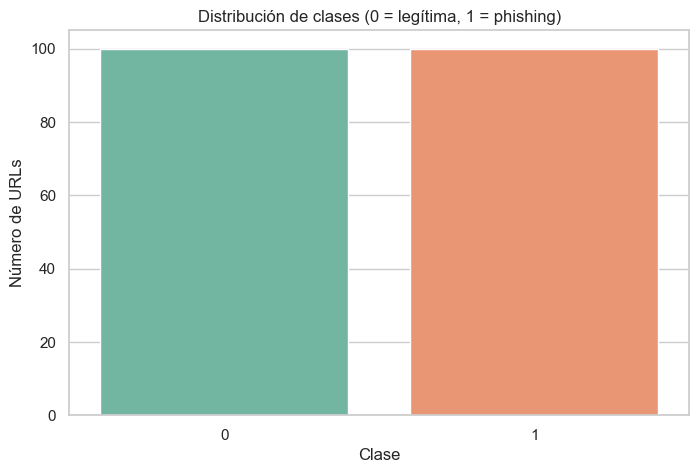


Distribución por categorías (legítimas vs phishing):
label                0   1
categoria                 
banca               37  37
cripto               5   5
energía              1   1
gaming               3   3
genérico            18  18
logística            7   7
público              7   7
rrss                 1   1
saas                 9   9
streaming            5   5
telecomunicaciones   7   7


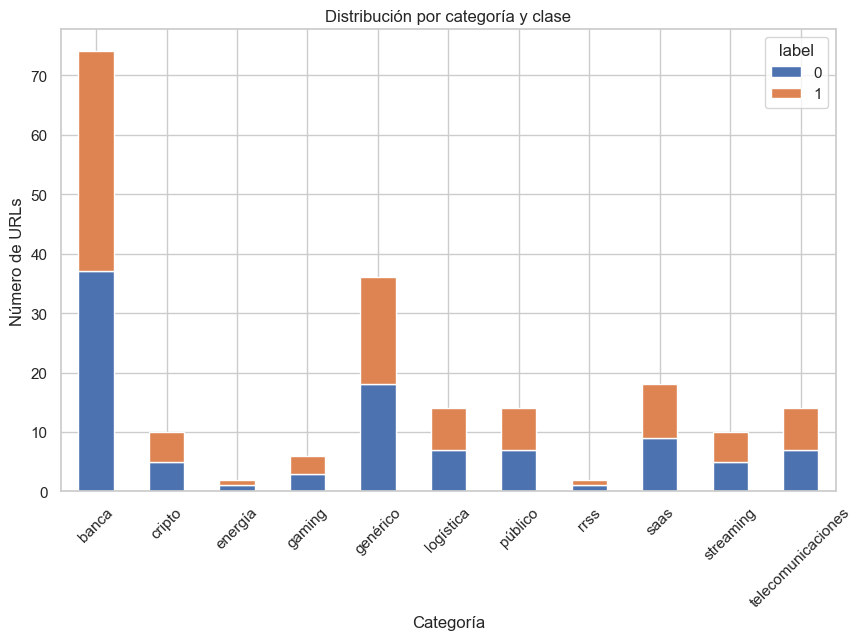

In [3]:
# Balance de clases
print("Balance de clases:")
print(df["label"].value_counts())

sns.countplot(x="label", data=df, palette="Set2")
plt.title("Distribución de clases (0 = legítima, 1 = phishing)")
plt.xlabel("Clase")
plt.ylabel("Número de URLs")
plt.show()

# Distribución por categorías
categoria_counts = df.groupby(["categoria","label"]).size().unstack(fill_value=0)

print("\nDistribución por categorías (legítimas vs phishing):")
print(categoria_counts)

categoria_counts.plot(kind="bar", stacked=True, figsize=(10,6))
plt.title("Distribución por categoría y clase")
plt.ylabel("Número de URLs")
plt.xlabel("Categoría")
plt.xticks(rotation=45)
plt.show()


In [4]:
# Longitud total de la URL
df["url_length"] = df["url"].str.len()

# Dominio y longitud de dominio
df["domain"] = df["url"].apply(lambda x: tldextract.extract(x).domain + "." + tldextract.extract(x).suffix)
df["domain_length"] = df["domain"].str.len()

# Profundidad de la ruta (número de '/')
df["path_depth"] = df["url"].str.count("/")

# Número de parámetros (? y &)
df["num_params"] = df["url"].str.count("\?") + df["url"].str.count("&")

# Caracteres especiales relevantes
for c in ["@", "-", "_", "%", "="]:
    df[f"contains_{c}"] = df["url"].str.contains(c).astype(int)

df[["url","url_length","domain_length","path_depth","num_params"]].head()


,url,url_length,domain_length,path_depth,num_params
0,https://www.caixabank.es/particular/banca-digi...,54,12,4,0
1,https://accounts.google.com/ServiceLogin?servi...,53,10,3,1
2,https://www.roblox.com/es/upgrades/robux?ctx=n...,55,10,5,1
3,https://zoom.us/es/join,23,7,4,0
4,https://www.roblox.com/es/login,31,10,4,0


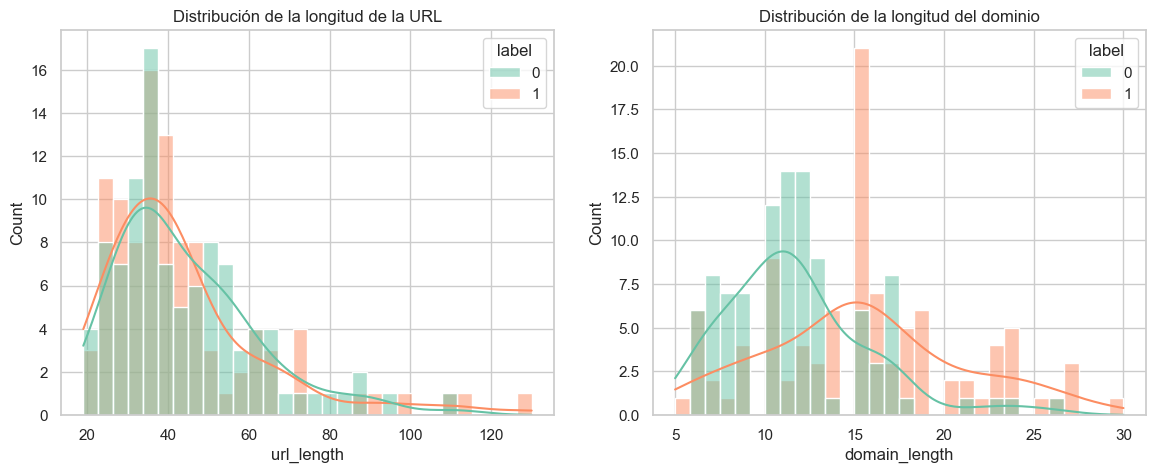

/var/folders/fc/53j7mrrs40j5jvl09zqzrcqw0000gn/T/ipykernel_61592/3893026421.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="label", y="path_depth", data=df, palette="Set2", ax=axes[0])
/var/folders/fc/53j7mrrs40j5jvl09zqzrcqw0000gn/T/ipykernel_61592/3893026421.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="label", y="num_params", data=df, palette="Set2", ax=axes[1])


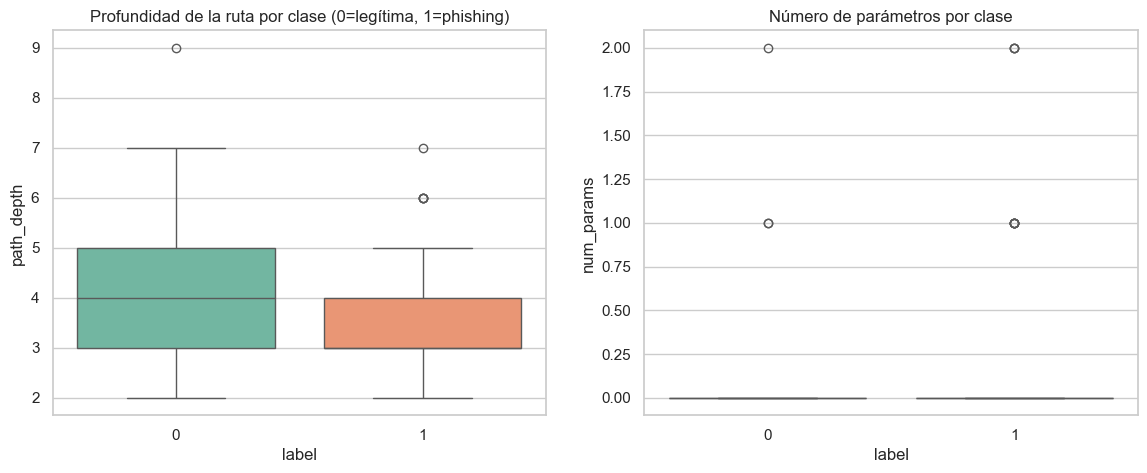

In [5]:
# Histogramas comparativos de longitud de URL y dominio
fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.histplot(data=df, x="url_length", hue="label", bins=30, kde=True, ax=axes[0], palette="Set2")
axes[0].set_title("Distribución de la longitud de la URL")

sns.histplot(data=df, x="domain_length", hue="label", bins=30, kde=True, ax=axes[1], palette="Set2")
axes[1].set_title("Distribución de la longitud del dominio")

plt.show()

# Boxplots de profundidad de ruta y número de parámetros
fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.boxplot(x="label", y="path_depth", data=df, palette="Set2", ax=axes[0])
axes[0].set_title("Profundidad de la ruta por clase (0=legítima, 1=phishing)")

sns.boxplot(x="label", y="num_params", data=df, palette="Set2", ax=axes[1])
axes[1].set_title("Número de parámetros por clase")

plt.show()


In [6]:
# Resumen estadístico por clase
print("📊 Estadísticas descriptivas por clase (0=legítima, 1=phishing):\n")
print(df.groupby("label")[["url_length","domain_length","path_depth","num_params"]].describe())

# Promedios simples para interpretación rápida
print("\n📌 Promedios por clase:")
print(df.groupby("label")[["url_length","domain_length","path_depth","num_params"]].mean())

# Frecuencia de caracteres especiales por clase
char_cols = ["contains_@", "contains_-", "contains__","contains_%","contains_="]
print("\n🔎 Presencia de caracteres especiales en URLs:")
print(df.groupby("label")[char_cols].sum())


📊 Estadísticas descriptivas por clase (0=legítima, 1=phishing):

      url_length                                                    \
           count   mean        std   min   25%   50%    75%    max   
label                                                                
0          100.0  44.33  17.566644  19.0  32.0  39.0  53.25  111.0   
1          100.0  43.54  20.247170  21.0  31.0  39.0  47.00  130.0   

      domain_length         ... path_depth      num_params                  \
              count   mean  ...        75%  max      count  mean       std   
label                       ...                                              
0             100.0  11.70  ...        5.0  9.0      100.0  0.04  0.242878   
1             100.0  15.42  ...        4.0  7.0      100.0  0.12  0.408990   

                                
       min  25%  50%  75%  max  
label                           
0      0.0  0.0  0.0  0.0  2.0  
1      0.0  0.0  0.0  0.0  2.0  

[2 rows x 32 columns]

📌 Pr

🔎 Top 10 TLDs en URLs legítimas:
tld
es         59
com        34
gob.es      4
us          1
network     1
net         1
Name: count, dtype: int64

🔎 Top 10 TLDs en URLs phishing:
tld
com        44
es         15
me          5
app         5
com.es      5
net         4
digital     4
info        3
io          2
top         2
Name: count, dtype: int64


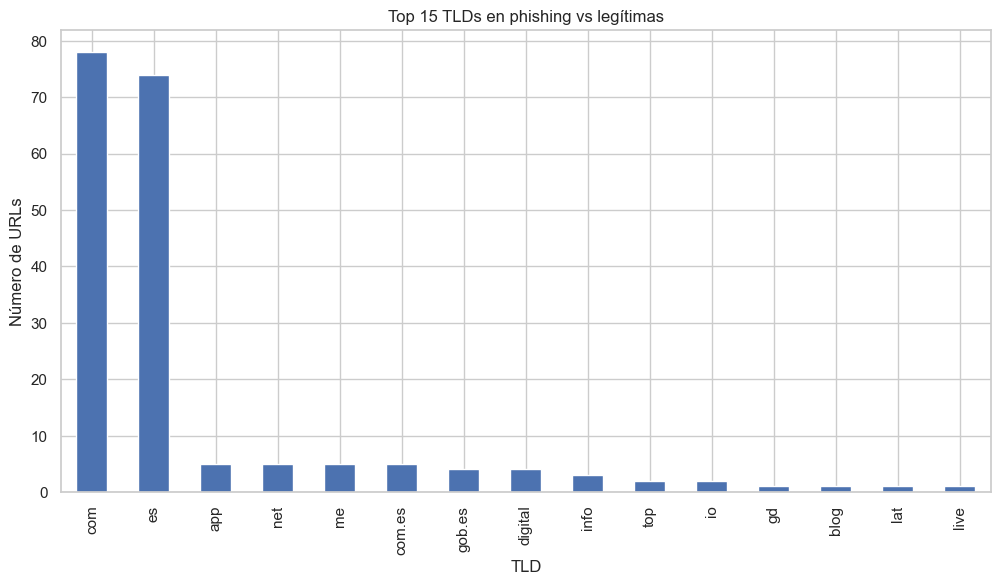


🔎 Top 10 dominios en URLs legítimas:
domain
bbva.es              5
bancosantander.es    4
ing.es               4
unicajabanco.es      4
caixabank.es         3
ibercaja.es          3
openbank.es          3
abanca.com           3
ionos.es             3
bancsabadell.com     3
Name: count, dtype: int64

🔎 Top 10 dominios en URLs phishing:
domain
webcindario.com                11
google.com                      4
ead.me                          3
blogspot.com                    2
web.app                         2
ing-es-movil.com                2
direct-ayuda.com                2
ing-appmovil-inicio.com         2
multa.net                       2
authline-checkappr0v.com.es     2
Name: count, dtype: int64


In [7]:
# Extraer TLD (extensión de dominio)
df["tld"] = df["url"].apply(lambda x: tldextract.extract(x).suffix)

# Top TLDs por clase
print("🔎 Top 10 TLDs en URLs legítimas:")
print(df[df["label"]==0]["tld"].value_counts().head(10))

print("\n🔎 Top 10 TLDs en URLs phishing:")
print(df[df["label"]==1]["tld"].value_counts().head(10))

# Visualización TLDs principales
tld_counts = df.groupby(["tld","label"]).size().unstack(fill_value=0)
top_tlds = tld_counts.sum(axis=1).sort_values(ascending=False).head(15)

top_tlds.plot(kind="bar", stacked=True, figsize=(12,6))
plt.title("Top 15 TLDs en phishing vs legítimas")
plt.ylabel("Número de URLs")
plt.xlabel("TLD")
plt.show()

# Top dominios por clase
print("\n🔎 Top 10 dominios en URLs legítimas:")
print(df[df["label"]==0]["domain"].value_counts().head(10))

print("\n🔎 Top 10 dominios en URLs phishing:")
print(df[df["label"]==1]["domain"].value_counts().head(10))


🔎 Protocolos en legítimas:
protocol
https    100
Name: count, dtype: int64

🔎 Protocolos en phishing:
protocol
https    85
http     15
Name: count, dtype: int64


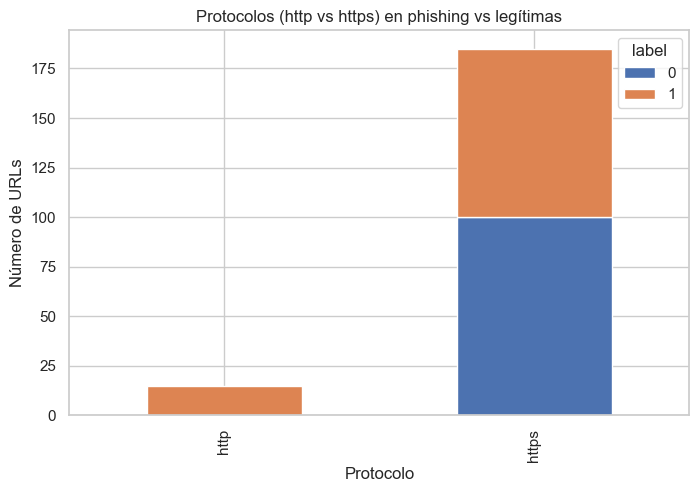

In [8]:
# Extraer protocolo
df["protocol"] = df["url"].apply(lambda x: x.split(":")[0])

# Conteo por clase
print("🔎 Protocolos en legítimas:")
print(df[df["label"]==0]["protocol"].value_counts())

print("\n🔎 Protocolos en phishing:")
print(df[df["label"]==1]["protocol"].value_counts())

# Visualización
protocol_counts = df.groupby(["protocol","label"]).size().unstack(fill_value=0)

protocol_counts.plot(kind="bar", stacked=True, figsize=(8,5))
plt.title("Protocolos (http vs https) en phishing vs legítimas")
plt.ylabel("Número de URLs")
plt.xlabel("Protocolo")
plt.show()


In [19]:
# Extraer tokens de dominio y de ruta
def tokenize_domain(url):
    ext = tldextract.extract(url)
    domain_part = ".".join([ext.subdomain, ext.domain])  # subdominio + dominio
    tokens = re.split(r"[.\-]", domain_part.lower())
    return [t for t in tokens if len(t) > 2]

def tokenize_path(url):
    path = url.split("://")[-1].split("/",1)
    if len(path) == 2:
        path = path[1]
    else:
        path = ""
    tokens = re.split(r"[\/\-\_\=\?\&\.]", path.lower())
    return [t for t in tokens if len(t) > 2]

# Generar tokens para cada clase
tokens_domain_legit, tokens_domain_phish = [], []
tokens_path_legit, tokens_path_phish = [], []

for _, row in df.iterrows():
    if row["label"] == 0:
        tokens_domain_legit.extend(tokenize_domain(row["url"]))
        tokens_path_legit.extend(tokenize_path(row["url"]))
    else:
        tokens_domain_phish.extend(tokenize_domain(row["url"]))
        tokens_path_phish.extend(tokenize_path(row["url"]))

# Mostrar top tokens
print("🔎 Top 15 tokens en dominios legítimos:")
print(Counter(tokens_domain_legit).most_common(15))

print("\n🔎 Top 15 tokens en dominios phishing:")
print(Counter(tokens_domain_phish).most_common(15))

print("\n🔎 Top 15 tokens en rutas legítimas:")
print(Counter(tokens_path_legit).most_common(15))

print("\n🔎 Top 15 tokens en rutas phishing:")
print(Counter(tokens_path_phish).most_common(15))


🔎 Top 15 tokens en dominios legítimos:
[('www', 69), ('ing', 5), ('bbva', 5), ('unicajabanco', 4), ('bancosantander', 4), ('caixabank', 3), ('ibercaja', 3), ('bancsabadell', 3), ('sede', 3), ('dgt', 3), ('univia', 3), ('ionos', 3), ('abanca', 3), ('openbank', 3), ('bankinter', 3)]

🔎 Top 15 tokens en dominios phishing:
[('webcindario', 11), ('www', 10), ('ing', 7), ('app', 4), ('cuenta', 4), ('web', 4), ('sites', 4), ('google', 4), ('ead', 3), ('cliente', 3), ('com', 3), ('netflix', 3), ('authline', 2), ('checkappr0v', 2), ('direct', 2)]

🔎 Top 15 tokens en rutas legítimas:
[('login', 15), ('banca', 11), ('particulares', 10), ('html', 9), ('cuenta', 5), ('personal', 5), ('online', 5), ('pago', 4), ('empresas', 4), ('app', 4), ('ayuda', 4), ('seguridad', 4), ('home', 4), ('cliente', 3), ('bsnacional', 3)]

🔎 Top 15 tokens en rutas phishing:
[('php', 9), ('html', 7), ('login', 6), ('index', 5), ('view', 4), ('p%c3%a1gina', 4), ('principal', 4), ('com', 3), ('inicio', 3), ('ing', 2), ('dr

In [14]:
# Mostrar top tokens como tabla
print("✅ Top 20 tokens en legítimas (ordenados por frecuencia):\n")
display(pd.DataFrame(Counter(tokens_legit).most_common(20), columns=["token","count"]))

print("\n✅ Top 20 tokens en phishing (ordenados por frecuencia):\n")
display(pd.DataFrame(Counter(tokens_phish).most_common(20), columns=["token","count"]))


✅ Top 20 tokens en legítimas (ordenados por frecuencia):



,token,count
0,https:,100
1,www,69
2,com,34
3,login,17
4,banca,11
5,particulares,10
6,html,9
7,ing,7
8,ionos,6
9,cuenta,5



✅ Top 20 tokens en phishing (ordenados por frecuencia):



,token,count
0,https:,85
1,com,56
2,http:,15
3,webcindario,11
4,www,10
5,php,9
6,ing,9
7,app,9
8,login,7
9,html,7


📊 Entropía media por clase:
label
0    3.039612
1    3.283882
Name: domain_entropy, dtype: float64


/var/folders/fc/53j7mrrs40j5jvl09zqzrcqw0000gn/T/ipykernel_61592/4083771261.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="label", y="domain_entropy", data=df, palette="Set2")


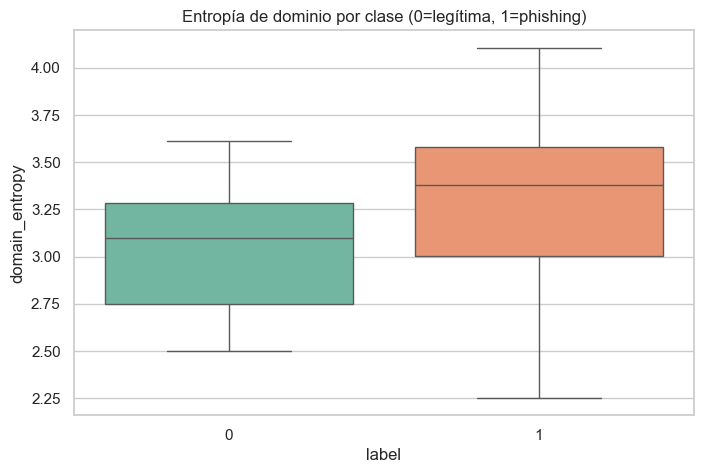

In [18]:
from math import log2

# Función para calcular la entropía de Shannon
def shannon_entropy(s):
    if not s:
        return 0
    prob = [float(s.count(c)) / len(s) for c in dict.fromkeys(list(s))]
    return -sum([p * log2(p) for p in prob])

# Calcular entropía del dominio
df["domain_entropy"] = df["domain"].apply(shannon_entropy)

# Estadísticas descriptivas
print("📊 Entropía media por clase:")
print(df.groupby("label")["domain_entropy"].mean())

# Visualización
sns.boxplot(x="label", y="domain_entropy", data=df, palette="Set2")
plt.title("Entropía de dominio por clase (0=legítima, 1=phishing)")
plt.show()


# 11. Features candidatas para el modelo

A partir del análisis exploratorio, se identificaron las siguientes variables potencialmente útiles:

## 🔹 Estructurales
- `url_length` → longitud total de la URL.
- `domain_length` → longitud del dominio.
- `path_depth` → número de `/` en la ruta.
- `num_params` → número de parámetros (`?`, `&`).
- `domain_entropy` → entropía del dominio.

## 🔹 Caracteres y símbolos
- `contains_@`
- `contains_-`
- `contains__`
- `contains_%`
- `contains_=`  

## 🔹 Protocolos y TLDs
- `protocol` (http/https).
- `tld` → indicador de TLD sospechoso/infrecuente.

## 🔹 Tokens
- **Dominio**:
  - Presencia de marcas oficiales (`bbva`, `santander`, `ing`, etc.).
  - Presencia de hostings gratuitos (`webcindario`, `blogspot`, `sites`, etc.).
- **Ruta**:
  - Palabras sospechosas (`php`, `html`, `index`, `view`, `cliente`, `inicio`).
  - Palabras de confianza (`seguridad`, `banca`, `empresas`, `ayuda`).
  - Tokens codificados o aleatorios (`%c3%a1`, cadenas con símbolos).

---

Estas features serán la base del siguiente paso:  
➡️ **Notebook de Feature Engineering**, donde se construirán las columnas derivadas y se generará un dataset listo para entrenamiento.
